# Variación del NDVI en la Vegetación de España continental

## Como el clima mediterráneo varía la calidad de la vegetación a lo largo de un año

# 0. Referencia: 

Me he basado en el siguiente vídeo para hacer la animación del NDVI.

In [1]:
import geemap

geemap.show_youtube("OwjSJnGWKJs")

Output(layout=Layout(width='815px'))

# 1. Inicializamos Earth Engine API.

En el repositorio debo de tener incluido un archivo de texto ``requirements.txt `` con todas las librerías que he usado. 

In [2]:
import os
import ee

# Inicializar Earth Engine
ee.Initialize()

# 2. Area de estudio. 

Elijo un tramo del curso medio del Tajo, en la provincia de Cáceres, cerca del término municipal de Talaván.

In [27]:
# Definir geometría. Una parcela del Tajo
geometry = ee.Geometry.Polygon(
    [[[-6.327549926313669, 39.70071236736919],
      [-6.14524554398945, 39.70071236736919],
      [-6.14524554398945, 39.800224918050205],
      [-6.327549926313669, 39.800224918050205],
      [-6.327549926313669, 39.70071236736919]]])


# Cargar la colección de imágenes Sentinel-2
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(geometry) \
    .filterDate('2023-01-01', '2023-12-31') \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 40)

### Visualizamos True Color: 

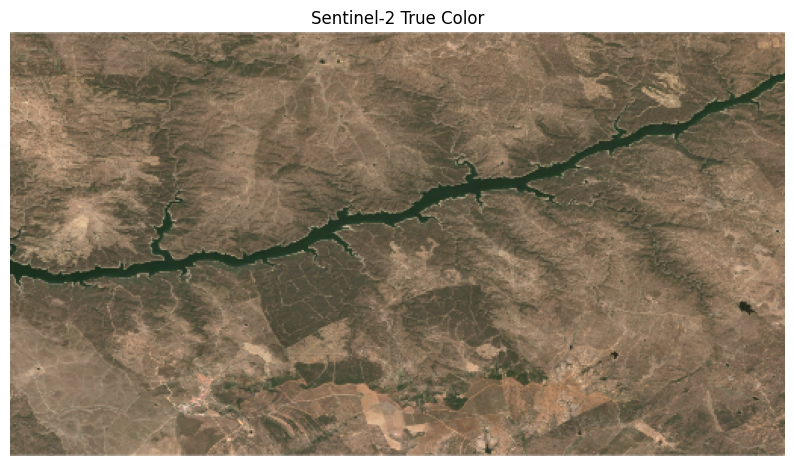

In [34]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import urllib.request

s2_image = s2.median().clip(geometry)

# Seleccionar las bandas para color verdadero (B4, B3, B2)
true_color = s2_image.select(['B4', 'B3', 'B2'])

# Configurar parámetros de visualización
vis_params = {
    'min': 0,
    'max': 3000,
    'gamma': 1.5
}


# Obtener la URL para visualizar la imagen
url = true_color.getThumbURL({
    'region': geometry,
    'dimensions': 512,
    'format': 'png',
    'min': vis_params['min'],
    'max': vis_params['max'],
    'gamma': vis_params['gamma']
})

# Descargar la imagen usando Pillow y urllib
image_data = np.array(Image.open(urllib.request.urlopen(url)))

# Plotear la imagen con matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image_data)
plt.axis('off')
plt.title('Sentinel-2 True Color')
plt.show()

Por lo que vemos, es una región representativa del interior de la Península Ibérica. Un paisaje formado por distintos usos de suelo, tanto agrarios como forestales.

### CORINE LandCover

In [37]:
import matplotlib.patches as mpatches

# Cargar la colección CORINE Land Cover
corine = ee.ImageCollection('COPERNICUS/CORINE/V20/100m')

# Filtrar la colección por la región de interés
image = corine.filterBounds(geometry).first()

# Definir los colores para las clases de vegetación en CORINE detectadas
corine_palette = {
    131: '#e5ccff',  # Mineral extraction sites
    211: '#ff0000',  # Non-irrigated arable land
    222: '#ffcc99',  # Fruit trees and berry plantations
    223: '#ff9900',  # Olive groves
    242: '#ff6600',  # Complex cultivation patterns
    244: '#ff3300',  # Agro-forestry areas
    321: '#66ff66',  # Natural grasslands
    323: '#33cc33',  # Sclerophyllous vegetation
    324: '#009900',  # Transitional woodland-shrub
    512: '#0066ff',  # Water bodies
}

# Obtener los valores únicos de clases en la región
unique_values = image.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=geometry,
    scale=100,
    maxPixels=1e8
).get('landcover').getInfo()

# Imprimir los valores únicos detectados en la región
print("Unique land cover classes in the region:", unique_values)

# Filtrar los valores únicos para solo incluir los presentes en la región
present_classes = {int(k): corine_palette[int(k)] for k in unique_values.keys() if int(k) in corine_palette}

# Crear los parámetros de visualización
vis_params = {
    'min': 1,
    'max': 511,
    'palette': list(present_classes.values())
}

# Obtener la URL para visualizar la imagen
url = image.getThumbURL({
    'region': geometry,
    'dimensions': 512,
    'format': 'png',
    'min': vis_params['min'],
    'max': vis_params['max'],
    'palette': vis_params['palette']
})

# Descargar la imagen usando Pillow y urllib
image_data = np.array(Image.open(urllib.request.urlopen(url)))

Unique land cover classes in the region: {'131': 34, '211': 40.96078431372549, '222': 266.5882352941176, '223': 100, '242': 319.6, '244': 7121.254901960784, '321': 1433.8235294117644, '323': 1300.5450980392156, '324': 5978.098039215684, '512': 667.4980392156863}


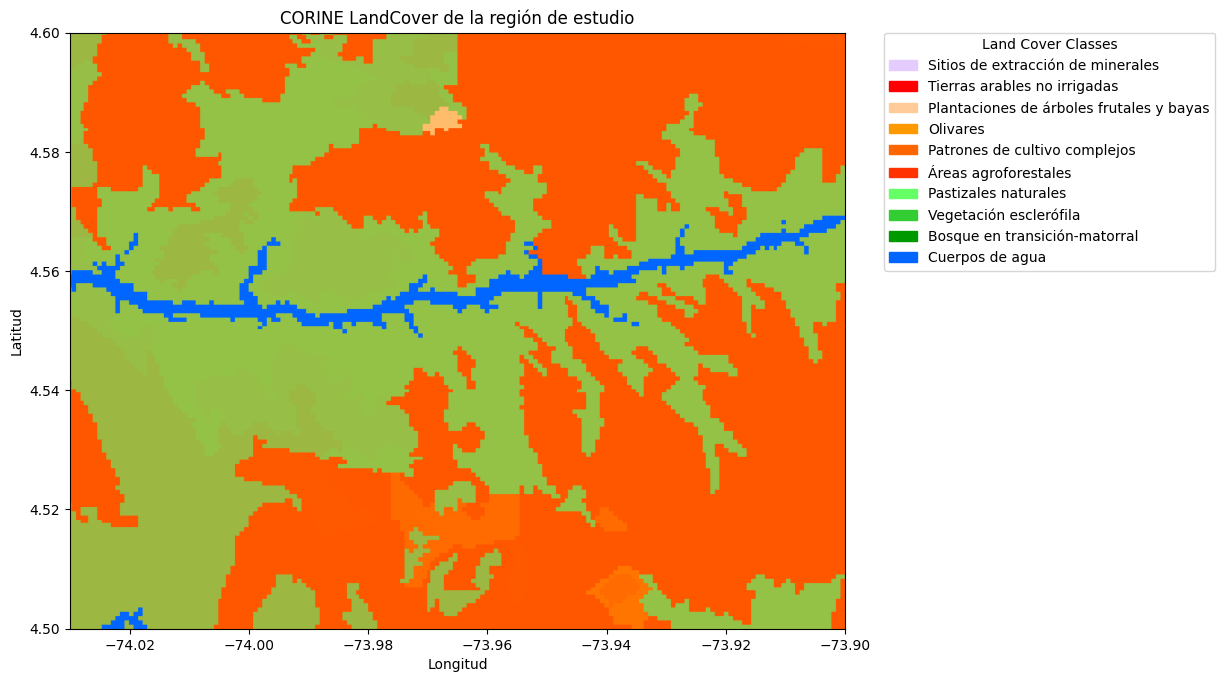

In [38]:
# Plotear la imagen con matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_data, extent=[-74.03, -73.9, 4.5, 4.6])
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_title('CORINE LandCover de la región de estudio')

# Crear la leyenda
legend_labels = {
    131: 'Sitios de extracción de minerales',
    211: 'Tierras arables no irrigadas',
    222: 'Plantaciones de árboles frutales y bayas',
    223: 'Olivares',
    242: 'Patrones de cultivo complejos',
    244: 'Áreas agroforestales',
    321: 'Pastizales naturales',
    323: 'Vegetación esclerófila',
    324: 'Bosque en transición-matorral',
    512: 'Cuerpos de agua'
}
handles = [mpatches.Patch(color=color, label=legend_labels[key]) for key, color in present_classes.items()]
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Land Cover Classes")

plt.show()

Sabiendo lo que más o menos se compone el paisaje, podemos intuir como va a responder la vegetación ante los meses de sequía y como va a variar su NDVI a lo largo del año. 

En este caso, viendo la vegetación boscosa alrededor del río y los bastos terrenos dedicados a cultivos y sistemas agroforestales podemos imaginar que el paisaje va a tener un NDVI heterogéneo.

# 3. Creación de NDVI

Primero dejamos creada la paleta para representar los niveles de NDVI:

In [5]:
# Una paleta de NDVI agradable
palette = [
    '3F448C', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
    '74A901', '66A000', '529400', '3E8601', '207401', '056201',
    '004C00', '023B01', '012E01', '011D01', '011301']

Creamos las funciones y sacamos el índice de `Sentinel 2`

In [6]:
# Función para calcular el NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Aplicar la función a la colección de imágenes
ndvi_collection = s2.map(calculate_ndvi)

# Crear una imagen compuesta mensual
def get_monthly_image(m):
    start = ee.Date.fromYMD(2023, m, 1)
    end = start.advance(1, 'month')
    monthly_image = ndvi_collection.filterDate(start, end).median()
    return monthly_image.set('month', m)

monthly_ndvi = ee.ImageCollection(ee.List.sequence(1, 12).map(get_monthly_image))

Creamos los parámetros, tanto de imagen como de la animación

In [7]:
# Visualización de parámetros
vis_params = {
    'min': 0,
    'max': 1,
    'palette': palette
}

# Definir argumentos para la animación
video_args = {
    "dimensions": 600,
    "region": geometry,
    "framesPerSecond": 1,
    "bands": ["NDVI"],
    "min": 0,
    "max": 1,
    "palette": palette
}

Descargamos la animación en formato GIF en nuestro directorio

In [8]:
# Establecer el directorio de trabajo
work_dir = os.path.join(os.path.expanduser("~"), "Downloads")
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

out_gif = os.path.join(work_dir, "ndvi_monthly_animation.gif")

# Descargar el video como GIF
geemap.download_ee_video(monthly_ndvi, video_args, out_gif)

# Crear una lista de etiquetas mensuales
months = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

Generating URL...
Please wait ...
The GIF image has been saved to: C:\Users\danie\Downloads\ndvi_monthly_animation.gif


Añadimos texto y representamos

In [9]:
# Añadir texto de cada mes a cada fotograma del GIF
texted_gif = os.path.join(work_dir, "ndvi_monthly_animation_with_text.gif")
geemap.add_text_to_gif(out_gif, texted_gif, xy=("2%", "88%"), text_sequence=months, font_size=30, font_color="ffffff", progress_bar_color="cyan", duration=1000)

# Mostrar el GIF resultante
geemap.show_image(texted_gif)

Output()

Vemos que las diferencias entre invierno y verano son brutales, incluso para la vegetación de bosque de rivera algunos meses son especialmente estresante. 

También creo que es interesante ver lo rápido que se recupera con las lluvias de otoño, disparando la calidad de las plantas en apenas un mes

# 4. Time Series de NDVI

Vamos a crear un gráfico que siga los valores medios del NDVI (del paisaje en su conjunto) a lo largo del año: 

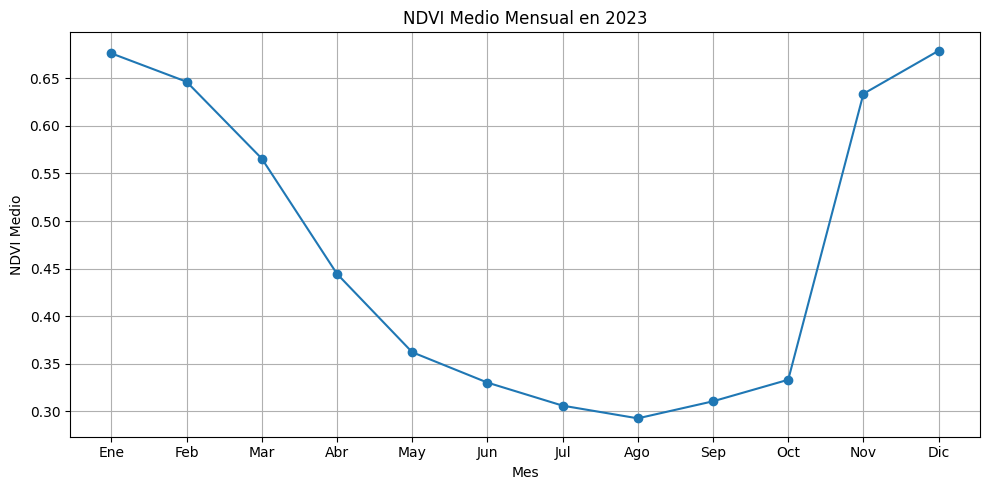

In [60]:
import pylab as plt

# Crear una imagen compuesta mensual y calcular el NDVI medio
def get_monthly_image(m):
    start = ee.Date.fromYMD(2023, m, 1)
    end = start.advance(1, 'month')
    monthly_image = ndvi_collection.filterDate(start, end).median()
    ndvi_mean = monthly_image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=10,
        maxPixels=1e9
    ).get('NDVI')
    return monthly_image.set('month', m).set('NDVI_mean', ndvi_mean)

monthly_ndvi = ee.ImageCollection(ee.List.sequence(1, 12).map(get_monthly_image))

# Extraer los valores medios de NDVI para cada mes
ndvi_mean_list = monthly_ndvi.aggregate_array('NDVI_mean').getInfo()

# Crear la serie temporal
months = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]
if len(ndvi_mean_list) != len(months):
    raise ValueError("La longitud de ndvi_mean_list no coincide con la longitud de months")

plt.figure(figsize=(10, 5))
plt.plot(months, ndvi_mean_list, marker='o')
plt.title('NDVI Medio Mensual en 2023')
plt.xlabel('Mes')
plt.ylabel('NDVI Medio')
plt.grid(True)
plt.tight_layout()

In [61]:
# Guardar la gráfica de la serie temporal
timeseries_path = os.path.join(work_dir, 'ndvi_timeseries.png')
plt.savefig(timeseries_path)

<Figure size 640x480 with 0 Axes>

### Creamos una animación con el timeseries:

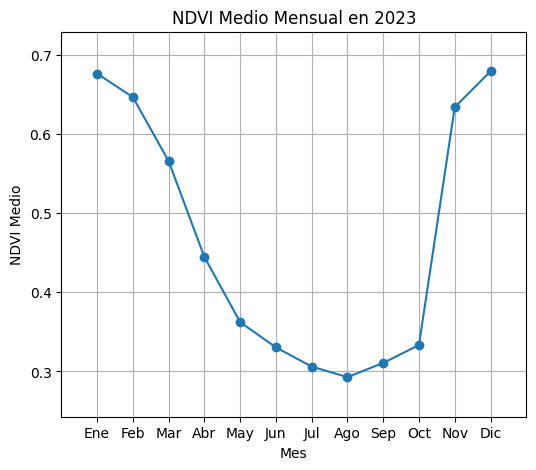

In [62]:
from matplotlib.animation import FuncAnimation


# Crear la animación de la serie temporal
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xlim(-1, len(months))
ax.set_ylim(min(ndvi_mean_list) - 0.05, max(ndvi_mean_list) + 0.05)
ax.set_title('NDVI Medio Mensual en 2023')
ax.set_xlabel('Mes')
ax.set_ylabel('NDVI Medio')
ax.grid(True)
line, = ax.plot([], [], marker='o')

def init():
    line.set_data([], [])
    return line,

def update(frame):
    x = months[:frame+1]
    y = ndvi_mean_list[:frame+1]
    line.set_data(range(len(x)), y)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x, rotation=0)
    return line,

ani = FuncAnimation(fig, update, frames=len(months), init_func=init, blit=True)

# Guardar la animación como GIF
work_dir = os.path.join(os.path.expanduser("~"), "Downloads")
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

timeseries_gif = os.path.join(work_dir, 'ndvi_timeseries_animation.gif')
ani.save(timeseries_gif, writer='pillow', fps=1)  # 1 frame per second to match the NDVI GIF

# Mostrar la animación
Image.open(timeseries_gif).show()

# 5. Combinación de las animaciones:

In [63]:
from IPython.display import display, HTML
import ipywidgets as widgets

# Aquí asumimos que ya tienes el GIF del NDVI mensual creado como 'ndvi_monthly_animation_with_text.gif'
ndvi_gif = os.path.join(work_dir, 'ndvi_monthly_animation_with_text.gif')

# Crear widgets de imagen para mostrar ambos GIFs
ndvi_image = widgets.Image(value=open(ndvi_gif, 'rb').read(), format='gif', width=400, height=400)
timeseries_image = widgets.Image(value=open(timeseries_gif, 'rb').read(), format='gif', width=400, height=400)

# Crear una caja de widgets para mostrar los GIFs uno al lado del otro
box = widgets.HBox([ndvi_image, timeseries_image])
display(box)

Usamos este script para juntarlos y guardarlos:

In [64]:
import os
from PIL import Image, ImageSequence
from IPython.display import display, HTML

# Aquí asumimos que ya tienes el GIF del NDVI mensual creado como 'ndvi_monthly_animation_with_text.gif'
ndvi_gif = os.path.join(work_dir, 'ndvi_monthly_animation_with_text.gif')

# GIF adicional de la serie temporal
timeseries_gif = os.path.join(work_dir, 'ndvi_timeseries_animation.gif')

# Combinar ambos GIFs en un solo GIF lado a lado
combined_gif_path = os.path.join(work_dir, 'combined_ndvi_animation.gif')

# Abrir ambos GIFs
ndvi_frames = Image.open(ndvi_gif)
timeseries_frames = Image.open(timeseries_gif)

# Asegurarse de que ambos GIFs tienen el mismo número de frames
ndvi_frame_list = [frame.copy() for frame in ImageSequence.Iterator(ndvi_frames)]
timeseries_frame_list = [frame.copy() for frame in ImageSequence.Iterator(timeseries_frames)]

# Redimensionar frames para que tengan la misma altura
max_height = max(ndvi_frame_list[0].height, timeseries_frame_list[0].height)
ndvi_frame_list = [frame.resize((frame.width, max_height), Image.LANCZOS) for frame in ndvi_frame_list]
timeseries_frame_list = [frame.resize((frame.width, max_height), Image.LANCZOS) for frame in timeseries_frame_list]

# Combinar los frames uno al lado del otro
combined_frames = []
for ndvi_frame, timeseries_frame in zip(ndvi_frame_list, timeseries_frame_list):
    new_frame = Image.new('RGB', (ndvi_frame.width + timeseries_frame.width, max_height))
    new_frame.paste(ndvi_frame, (0, 0))
    new_frame.paste(timeseries_frame, (ndvi_frame.width, 0))
    combined_frames.append(new_frame)

# Guardar el nuevo GIF combinado
combined_frames[0].save(combined_gif_path, save_all=True, append_images=combined_frames[1:], loop=0, duration=1000)

# Mostrar el GIF combinado
display(HTML(f'<img src="{combined_gif_path}">'))